<div style="float:left">
    <h1 style="width:600px">Workshop 6: Advanced Regression</h1>
    <h3 style="width:600px">CASA0006: Data Science for Spatial Systems</h3>
    <h3 style="width:600px">CASA0009: Spatial Data Capture, Storage and Analysis</h3>
    <h3 style="width:600px">Author: Huanfa Chen</h3>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

In this workshop, we will be working through some examples of how we can use regression methods to understand the relationship between the bike rental data and ambient and seasonal variables.

This workshop will cover **linear regression**, **VIF**, **Lasso**, **CART**, **random forest**, and **GBDT**.

Let's first import the relevant libraries. 

* `pandas` for data import and handling;
* `matplotlib`;
* `numpy`;
* `sklearn`;
* `statsmodels` for linear regression and VIF.

**Run the script below to get started.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

## Data Exploration

The dataset you will use relates to daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C., along with weather and seasonal information. The goal here is to predict how many bikes will be rented depending on the weather and the day. The original data can be downloaded from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

The dataset used in this workshop has been slightly processed by Christoph Molnar using the processing R-script from this [Github repository](https://github.com/christophM/interpretable-ml-book/blob/master/R/get-bike-sharing-dataset.R). Here, the dataset is provided as a csv file on Moodle.

Here is a list of the variables in the dataset:

- Count of bicycles including both casual and registered users. The count is used as the response in the regression task.
- Indicator of the season, either spring, summer, fall or winter.
- Indicator whether the day was a holiday or not.
- The year: either 2011 or 2012.
- Number of days since the 01.01.2011 (the first day in the dataset). This predictor was introduced to take account of the trend over time.
- Indicator whether the day was a working day or weekend.
- The weather situation on that day. One of:
  - **'GOOD'**: including clear, few clouds, partly cloudy, cloudy
  - **'MISTY'**: including mist + clouds, mist + broken clouds, mist + few clouds, mist
  - **'RAIN/SNOW/STORM'**: including light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds, heavy rain + ice pallets + thunderstorm + mist, snow + mist
- Temperature in degrees Celsius.
- Relative humidity in percent (0 to 100).
- Wind speed in km/h.

Based on what you know from using Pandas over the last few weeks, import the Boston housing dataset as a Pandas dataframe (call it `bike_rental`), inspect the data, calculate summary statistics on all attributes, and general simple plots of pairs of attributes.

In [2]:
bike_rental = pd.read_csv('https://raw.githubusercontent.com/huanfachen/Spatial_Data_Science/main/Dataset/daily_count_bike_rental.csv')
# drop the year variable as it is not useful
bike_rental = bike_rental.drop(['yr'], axis=1)

In [3]:
bike_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cnt              731 non-null    int64  
 1   season           731 non-null    object 
 2   mnth             731 non-null    object 
 3   holiday          731 non-null    object 
 4   weekday          731 non-null    object 
 5   workingday       731 non-null    object 
 6   weathersit       731 non-null    object 
 7   temp             731 non-null    float64
 8   hum              731 non-null    float64
 9   windspeed        731 non-null    float64
 10  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 62.9+ KB


In [4]:
bike_rental.head()

,cnt,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,days_since_2011
0,985,SPRING,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.1758,80.5833,10.7499,0
1,801,SPRING,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.0835,69.6087,16.6521,1
2,1349,SPRING,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.2291,43.7273,16.6367,2
3,1562,SPRING,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.4000,59.0435,10.7398,3
4,1600,SPRING,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.6670,43.6957,12.5223,4


In `bike_rental`, there are two data types: categorical (aka `object`), and numerical (including `int64` and `float64`). 

Before undertaking regression, several steps should be done, which include:
- Converting categorical variables into dummy variables;
- Split the data into training and testing sets;
- For linear regression, we should deal with multicollinearity (and removing some variables if necessary)

### Converting categorical variables
First, we need to convert categorical variables into dummy/indicator variables, using `One-Hot Encoding`.

In [5]:
bike_rentail_numeric = pd.get_dummies(bike_rental)

In [6]:
# check out the new dataFrame
bike_rentail_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   temp                        731 non-null    float64
 2   hum                         731 non-null    float64
 3   windspeed                   731 non-null    float64
 4   days_since_2011             731 non-null    int64  
 5   season_FALL                 731 non-null    uint8  
 6   season_SPRING               731 non-null    uint8  
 7   season_SUMMER               731 non-null    uint8  
 8   season_WINTER               731 non-null    uint8  
 9   mnth_APR                    731 non-null    uint8  
 10  mnth_AUG                    731 non-null    uint8  
 11  mnth_DEZ                    731 non-null    uint8  
 12  mnth_FEB                    731 non-null    uint8  
 13  mnth_JAN                    731 non

Remember that, a cateogircal variable of K categories or levels, usually enters a regression as a sequence of K-1 dummy variables. The level that is left out becomes the reference level, and this is important for interpreting the regression model.

Here we manually choose the reference level for each categorical variable and exclude them from the DataFrame. You can change the reference levels if you want.

In [7]:
bike_rental_final = bike_rentail_numeric.drop(['season_SPRING', 'mnth_JAN', 'holiday_NO HOLIDAY', 'weekday_MON', 'workingday_WORKING DAY', 'weathersit_GOOD'], axis=1)

# double check the result
bike_rental_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cnt                         731 non-null    int64  
 1   temp                        731 non-null    float64
 2   hum                         731 non-null    float64
 3   windspeed                   731 non-null    float64
 4   days_since_2011             731 non-null    int64  
 5   season_FALL                 731 non-null    uint8  
 6   season_SUMMER               731 non-null    uint8  
 7   season_WINTER               731 non-null    uint8  
 8   mnth_APR                    731 non-null    uint8  
 9   mnth_AUG                    731 non-null    uint8  
 10  mnth_DEZ                    731 non-null    uint8  
 11  mnth_FEB                    731 non-null    uint8  
 12  mnth_JUL                    731 non-null    uint8  
 13  mnth_JUN                    731 non

### Splitting data into random train and test subsets

By default, `train_test_split` will split the data according to a 75:25 split. Other proportions can be specified, check out the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) for details.

Remember that the split should be random in order to avoid selection bias. Here, we set random_state=100 to guarantee reproducibility.

From the documentation:

The first argument of this function:

```
*arrays: sequence of indexables with same length / shape[0]
Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
```

The output of this function:
```
splitting: list, length=2 * len(arrays)
List containing train-test split of inputs.
```

Here we input two dataframes (X and Y) and will get four outputs (train_x, test_x, train_y, test_y).

In [8]:
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(bike_rental_final.drop(['cnt'], axis = 1), bike_rental_final.cnt, random_state=random_state_split)

Double check the rows and columns of the outputs.

In [9]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(548, 28)
(548,)
(183, 28)
(183,)
True
True


In the regression models, we will use the training set to train the model and select hyperparameters. The testing set is only used to report the performance of the finalised model.

### Checking multicollinearity

In regression, `multicollinearity` emerges when two or more variables, which are highly correlated are included in a model. It can emerge even when each pair of variables involved are not colinear. For example, think of the four dummy variables relating to seasons in the `bike_rental_numeric` dataset.  

You can check the colinearity between attributes using a correlation matrix as below. Think of these two questions:

- **What can you get from this plot? For example, which pair of variables are highly correlated, and can you explain it?**
- **Can you use the correlation matrix to deal with multicolinearity, for example, by removing one of the two variables if their correlation is above 0.75?** (*Hint*: a short answer is NO)

Text(0.5, 1.0, 'Correlation Matrix')

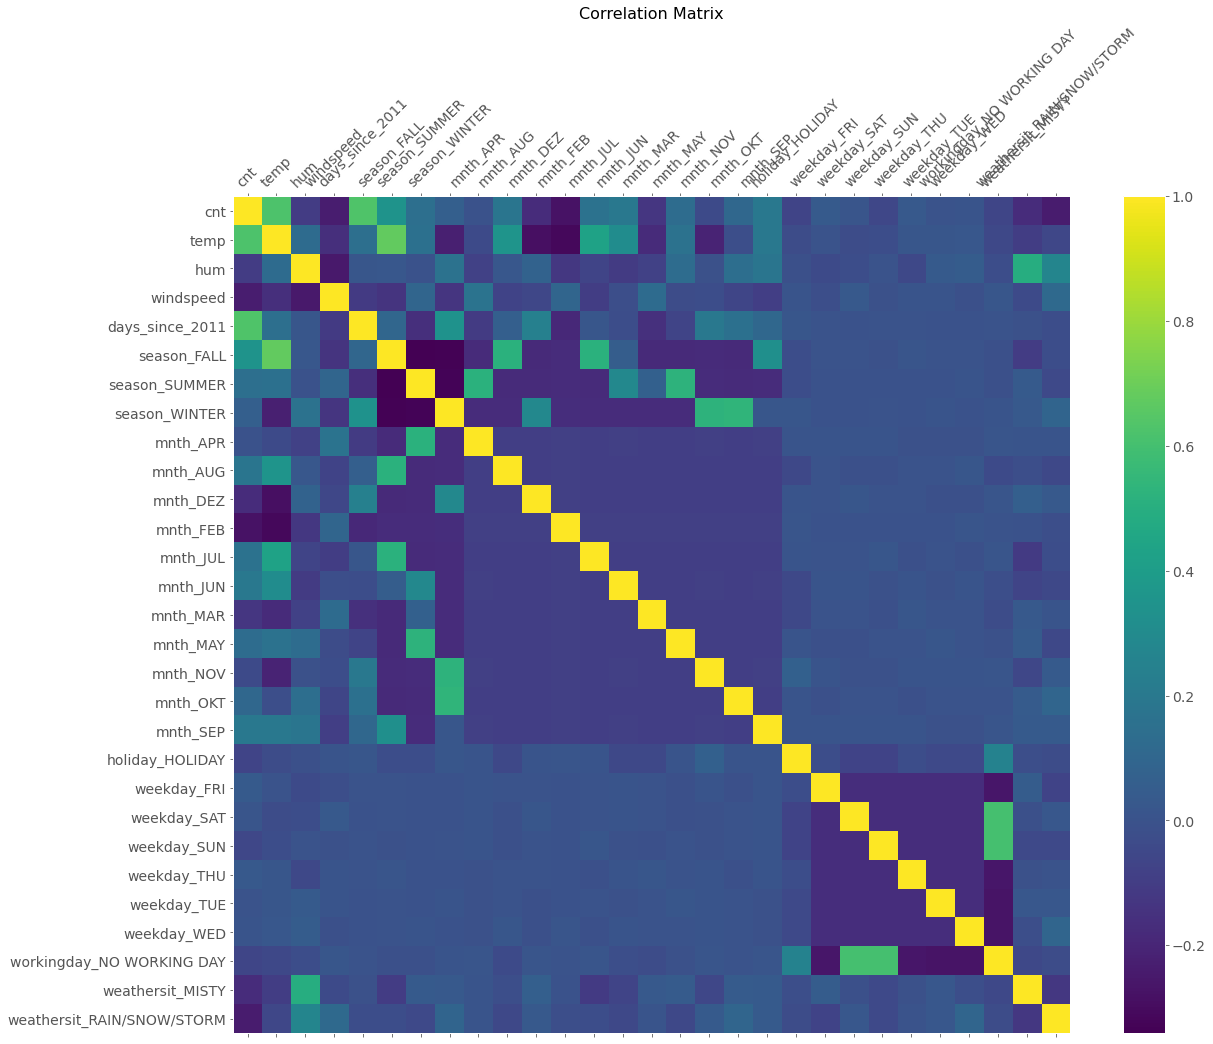

In [10]:
df = bike_rental_final
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

## Linear regression with VIF

The `Variance Inflation Factor` (VIF) is a measure of multicolinearity among predictors within a multiple regression task. It is the quotient of the variance in a model with multiple predictors by the variance of a model with a single predictor. More explanation of the theory can be found [here](https://en.wikipedia.org/wiki/Variance_inflation_factor). 

Steps for using VIF to deal with multicolineartiy are:

1. Initialise ```L``` as the list of independent variables. (*HINT*: the response variable is not needed here)
2. Calculate the VIF for each variable in ```L```. (*HINT*: the order of computing VIF is irrelevant).
3. If the highest VIF is larger than the threshold, remove the variable from the list ```L```.
4. Repeat Step 2-3, until no VIF is larger than the threshold.
5. Return ```L```.

Below is an example of using VIF on the `bike_rental` dataset. Note that the `statsmodels` package is used.

In [11]:
# calculating VIF
# This function is amended from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const as const should not be removed
        vif_df = vif_df.drop('const')
        
        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)
            
        print('Max VIF:', vif_df.VIF.max())
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [12]:
# using VIF on the bike_rental dataset

train_x_VIF = drop_column_using_vif_(train_x, thresh=5)
print("The columns remaining after VIF selection are:")
print(train_x_VIF.columns)

/Users/minghanwang/opt/anaconda3/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/minghanwang/opt/anaconda3/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Max VIF: inf
Dropping: holiday_HOLIDAY
Max VIF: 10.931616047006894
Dropping: season_FALL
Max VIF: 9.793644339692257
Dropping: workingday_NO WORKING DAY
Max VIF: 6.799588616502383
Dropping: temp
Max VIF: 5.52604957231624
Dropping: season_WINTER
Max VIF: 4.923880444783553
The columns remaining after VIF selection are:
Index(['hum', 'windspeed', 'days_since_2011', 'season_SUMMER', 'mnth_APR',
       'mnth_AUG', 'mnth_DEZ', 'mnth_FEB', 'mnth_JUL', 'mnth_JUN', 'mnth_MAR',
       'mnth_MAY', 'mnth_NOV', 'mnth_OKT', 'mnth_SEP', 'weekday_FRI',
       'weekday_SAT', 'weekday_SUN', 'weekday_THU', 'weekday_TUE',
       'weekday_WED', 'weathersit_MISTY', 'weathersit_RAIN/SNOW/STORM'],
      dtype='object')


### Building a linear regression model

Now we can fit a linear regression model after dealing with the multicolinearity, and we will do it using the sklearn package. 

Just like clustering analysis in `sklearn`, we will run the regression model using the `.fit()` function. Make sure you get the variables the right way around.

In [13]:
lr = LinearRegression()
lr.fit(X=train_x_VIF, y=train_y)

LinearRegression()

Now that we've created our fit, it's time to look at the structure of the model and how well it fits the data.

There are a number of ways to do this. In the first instance, as with any linear regression model, we want to get a grip on the coefficients and intercept of the model. Helpfully, these two functions are built into the LinearRegression object. **Consult the documentation and see if you can find out how to extract these.**

In [14]:
print('Constant term: ', lr.intercept_)
df_coef_lr_VIF = pd.DataFrame({"var": train_x_VIF.columns.values, "coef":lr.coef_})
print(df_coef_lr_VIF)

Constant term:  2087.803267162159
                           var                                     coef
0                          hum                                  -4.5649
1                    windspeed                                 -56.3497
2              days_since_2011                                   5.8236
3                season_SUMMER                                 364.1897
4                     mnth_APR                               1,609.4569
5                     mnth_AUG                               2,128.8620
6                     mnth_DEZ                                -566.6964
7                     mnth_FEB                                 367.0586
8                     mnth_JUL                               2,081.0410
9                     mnth_JUN                               2,317.6894
10                    mnth_MAR                               1,143.5983
11                    mnth_MAY                               2,127.0140
12                    mnth_NOV

The code below will generate the R2 score for us. Run the code and see how well the model performed.

In [15]:
print('R2:')
lr.score(X=train_x_VIF, y=train_y)

R2:


0.8093152572014565

It is not easy to get a comprehensive summary of the regression model using `sklearn` package. We recommend using the `statsmodel` package, which has a nice **summary()** function.

In [16]:
# fit a lineare regression model using statsmodel
regressor_OLS = sm.OLS(endog=train_y, exog=sm.add_constant(train_x_VIF)).fit()
regressor_OLS.summary()

/Users/minghanwang/opt/anaconda3/envs/sds2021/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     96.70
Date:                Fri, 25 Feb 2022   Prob (F-statistic):          7.90e-172
Time:                        15:08:15   Log-Likelihood:                -4476.3
No. Observations:                 548   AIC:                             9001.
Df Residuals:                     524   BIC:                             9104.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       2087.8033    293.832      7.105      0.000    1510.569    2665.037
hum                           -4.5649      3.602     -1.267      0.206     -11.642       2.512
windspeed                    -56.3497      7.908     -7.126      0.000     -71.885     -40.814
days_since_2011                5.8236      0.206     28.260      0.000       5.419       6.228
season_SUMMER                364.1897    192.511      1.892      0.059     -13.999     742.379
mnth_APR                    1609.4569    269.921      5.963      0.000    1079.196    2139.718
mnth_AUG                    2128.8620    184.336     11.549      0.000    1766.733    2490.991
mnth_DEZ                    -566.6964    192.280     -2.947      0.003    -944.431    -188.962
mnth_FEB                     367.0586    185.932      1.974      0.049       1.794     732.323
mnth_JUL                    2081.0410    193.825     10.737      0.000    1700.272    2461.810
mnth_JUN                    2317.6894    230.536     10.053      0.000    1864.801    2770.578
mnth_MAR                    1143.5983    186.451      6.134      0.000     777.316    1509.881
mnth_MAY                    2127.0140    265.211      8.020      0.000    1606.006    2648.022
mnth_NOV                     418.7691    192.969      2.170      0.030      39.681     797.857
mnth_OKT                    1626.9952    190.780      8.528      0.000    1252.207    2001.783
mnth_SEP                    2249.9567    194.271     11.582      0.000    1868.311    2631.603
weekday_FRI                  296.0104    143.319      2.065      0.039      14.459     577.562
weekday_SAT                  330.1010    138.105      2.390      0.017      58.793     601.409
weekday_SUN                 -143.5833    136.287     -1.054      0.293    -411.319     124.152
weekday_THU                  320.8964    144.275      2.224      0.027      37.468     604.325
weekday_TUE                  193.7411    139.470      1.389      0.165     -80.248     467.730
weekday_WED                  279.5822    141.534      1.975      0.049       1.538     557.626
weathersit_MISTY            -636.8467     98.186     -6.486      0.000    -829.732    -443.961
weathersit_RAIN/SNOW/STORM -2494.7931    255.733     -9.755      0.000   -2997.182   -1992.404
==============================================================================
Omnibus:                      103.552   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.576
Skew:                          -0.914   Prob(JB):                     1.08e-64
Kurtosis:                       6.092   Cond. No.                     5.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the 

The R2 value of 0.811 is quite high, which means that 81.1% of the variance in the daily bike rental can be explained by the predictors used.

The next step is interpreting this model. Regarding the humnidity, an increase of the humidity by 1% decreases the predicted bike rental count by 6.7672, when all other variables remain fixed. In terms of seasons, when it is fall, the predicted number of bike rental is 1120.6 higher compared to the spring season, when all other variables remain fixed. (So people like travelling by bicycle in fall more than in spring?)

As a practice, can you interpret the other variables in this model?

Now you can evaluate the model performance on the testing set.

In [17]:
# select the same columns from test_x as train_x_VIF
test_x_VIF = test_x[train_x_VIF.columns]

# using the model.score function to get the R2 on the testing data
lr.score(X=test_x_VIF, y=test_y)

0.7473959395730105

## Linear regression with Lasso

Lasso (which means **least absolute shrinkage and selection operator**) is a regression method that performs both variable selection and regularisation (or penalty) in order to increase the prediction accuracy and interpretability of the regression model.

In Lasso, the lambda (or alpha) parameter controls the strength of regularisation. If alpha=0, it is equivalent to an ordinary least square. 

Note that in the Lasso function provided by `sklearn`, the alpha value defaults to 1.0. But this value can be optimised.

Please note that Lasso requires predictors to be normalised. This can be done using this function by setting `normalize=True`. Here, normalisation means subtracting the mean and dividing by the standard deviation.

In [18]:
# increase the max_iter to guarantee convergence
lasso_model = sklearn.linear_model.Lasso(max_iter=10e7, normalize=True)
lasso_model.fit(X=train_x, y=train_y)

Lasso(max_iter=100000000.0, normalize=True)

In [19]:
lasso_model.score(X=train_x, y=train_y)

0.8479620073579042

It looks like the Lasso model has done a great job in fitting the data relationship in the training set.

We can check out the coefficients using the following code.

In [20]:
# print(lasso_model.coef_)
df_coef_lasso = pd.DataFrame({"var": train_x.columns.values, "coef":lasso_model.coef_})
print(df_coef_lasso)

                           var                                     coef
0                         temp                                 100.6733
1                          hum                                 -14.0132
2                    windspeed                                 -49.2467
3              days_since_2011                                   5.2862
4                  season_FALL                                   0.0000
5                season_SUMMER                                 718.3919
6                season_WINTER                                 621.7315
7                     mnth_APR                                   5.4039
8                     mnth_AUG                                   0.0000
9                     mnth_DEZ                              -1,153.4459
10                    mnth_FEB                                  -0.0000
11                    mnth_JUL                                -218.1984
12                    mnth_JUN                                  

We can apply the Lasso regression with a range of lambda parameters, and see how the coefficients change with the lambda value. The plot is called `LASSO Path`.

(-1.25, 4.25, -555.7763488553926, 1329.3797133596247)

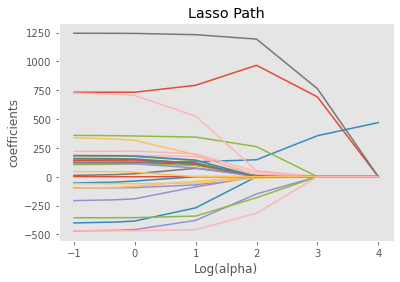

In [21]:
from itertools import cycle
from sklearn.linear_model import lasso_path

train_x_standard = train_x/train_x.std(axis=0)
list_alphas = [.1, .5, 1, 10, 100, 1000, 10000]

# alphas_lasso, coefs_lasso, _ = lasso_path(predictors_bike_rental, response_bike_rental, alphas = [.1, .5, 1, 10, 100], fit_intercept=False)
alphas_lasso, coefs_lasso, _ = lasso_path(train_x_standard, train_y.values.reshape(-1),alphas = list_alphas, fit_intercept=False)
# print(alphas_lasso.shape)
# print(coefs_lasso.shape)

log_alphas_lasso = np.log10(alphas_lasso)
for coef_l in coefs_lasso:
    l1 = plt.plot(log_alphas_lasso, coef_l)

plt.xlabel('Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso Path')
plt.axis('tight')

We will use cross validation to search for the optimal alpha value. The code below is based on [this link](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py).

What is the search range of alphas? 

The **lassoCV** function an argument called **alphas**, which is the list of alphas where to compute the models. Its default value is None. If None, alphas are set automatically.

As the automatically selected alpha values don't work well here (reason unknown), we will manually set alphas to list_alphas.

In [22]:
from sklearn.linear_model import LassoCV
import time

start_time = time.time()
lasso_cv = LassoCV(cv=20, alphas=list_alphas).fit(train_x, train_y)
fit_time = time.time() - start_time

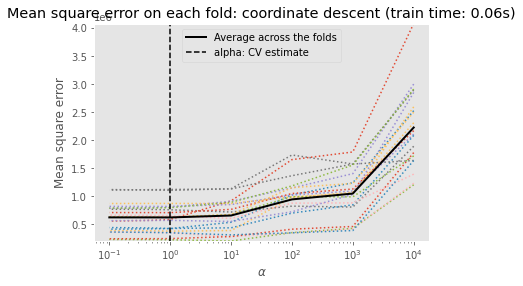

In [23]:
import matplotlib.pyplot as plt

ymin, ymax = np.min(lasso_cv.mse_path_), np.max(lasso_cv.mse_path_)
# lasso = model[-1]
plt.semilogx(lasso_cv.alphas_, lasso_cv.mse_path_, linestyle=":")
plt.plot(
    lasso_cv.alphas_,
    lasso_cv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso_cv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold: coordinate descent (train time: {fit_time:.2f}s)"
)

Print the **alphas_** values that have been compared.

In [24]:
print(lasso_cv.alphas_)

[1.e+04 1.e+03 1.e+02 1.e+01 1.e+00 5.e-01 1.e-01]


The optimal alpha value is as follows.

Note that this calculation contains some randomness and the mean square area of alpha=0.1 and alpha=1 is very close. Therefore, the optimal alpha might be 0.1 or 1 and might differ in different runs.

In [25]:
print(lasso_cv.alpha_)

1.0


Rerun the lasso model using the optimal alpha value:

In [26]:
# increase the max_iter to guarantee convergence
lasso_model = sklearn.linear_model.Lasso(max_iter=10e7, normalize=True, alpha = lasso_cv.alpha_)
lasso_model.fit(X=train_x, y=train_y)
print(lasso_model.score(train_x, train_y))

0.8479620073579042


How does this model perform on the testing data?

In [27]:
print(lasso_model.score(test_x, test_y))

0.7924788834408469


## Regression Tree

In this section, we will use a regression tree for this dataset. Although there are several parameters in this model such as **max_depth** (corresponding to the height of a tree), but in a first attempt we just use the default values.

In [28]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=0)
# if you don't remember the meaning of random_state, check out the lastest clustering workshop on Moodle
reg_tree.fit(train_x, train_y)

DecisionTreeRegressor(random_state=0)

Just like the previous regressors, you can check the R2 score using the `score()` function.

In [29]:
print("R2 on the training data:")
print(reg_tree.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(reg_tree.score(X=test_x, y=test_y))

R2 on the training data:
1.0
R2 on the testing data:
0.7229453566227575


It looks like the R2 on the testing data is much lower than that on the training data. This indicates the overfitting problem, meaning that it fits very well to the training data but fails to generalise to unseen data.

CART tends to overfit, and this issue can be reduced by **ensemble** methods which combine many many trees.

If you prefer RMSE as the performance metric, you can calculate it as follows (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)):

In [30]:
from sklearn.metrics import mean_squared_error
print("RMSE on the training data:")
print(mean_squared_error(train_y, reg_tree.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, reg_tree.predict(test_x), squared=False))

RMSE on the training data:
0.0
RMSE on the testing data:
986.8989988239838


### Interpretation of the regression tree

How many layers and leaf nodes are in this tree?

In [31]:
print("Depth of the regression tree: {}".format(reg_tree.get_depth()))
print("Number of nodes of this tree: {}".format(reg_tree.get_n_leaves()))

Depth of the regression tree: 25
Number of nodes of this tree: 548


As this tree has over 20 layers and hundreds of leaves, it is not useful to visualise this tree. 

Alternatively, we will use the Permutation Feature Importance (PFI) to evaluate the relative importance of each variable.

We will use the package of **rfpimp** to compute the variable importance. If this package is not installed, install it using ```pip install rfpimp```.

An introduction of this package is [here](https://github.com/parrt/random-forest-importances).

A good introduction to the permutation feature importance is [here](https://christophm.github.io/interpretable-ml-book/feature-importance.html).

In [32]:
#! pip install rfpimp

Note that the feature importance should be evaluated using the testing set, as it is unused in the model training.

We are interested in the top variables with a positive feature importance. These are days_since_2011, temp, hum, windspeed.

                                                         Importance
Feature                                                            
days_since_2011                                              0.7723
temp                                                         0.3846
windspeed                                                    0.1053
hum                                                          0.0700
mnth_OKT                                                     0.0173
weathersit_RAIN/SNOW/STORM                                   0.0140
mnth_APR                                                     0.0096
mnth_JUN                                                     0.0054
workingday_NO WORKING DAY                                    0.0048
weekday_FRI                                                  0.0028
mnth_SEP                                                     0.0025
weekday_SAT                                                  0.0018
holiday_HOLIDAY                                 

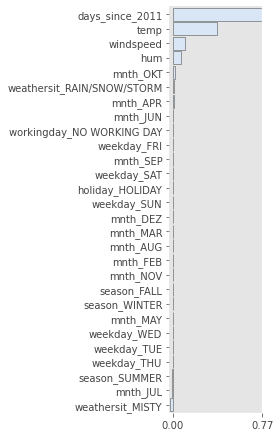

In [33]:
import rfpimp
imp = rfpimp.importances(reg_tree, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

## Random Forest

In this section, we will use the random forest method for this dataset.

In [34]:
from sklearn.ensemble import RandomForestRegressor
reg_random_forest = RandomForestRegressor(random_state=0)
reg_random_forest.fit(train_x, train_y)

RandomForestRegressor(random_state=0)

We can check the R2 score of this model.

In [35]:
print("R2 on the training data:")
print(reg_random_forest.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(reg_random_forest.score(X=test_x, y=test_y))

R2 on the training data:
0.9837757933204775
R2 on the testing data:
0.8850852018900764


So - what do you think about the comparison of R2 on the training and testing data?

As with CART, it is not useful to visualise the trees in a random forest.

Calculate and plot the feature importance of the RF model.

Although the feature importance value differs from the CART, the order of the top-ranking variables is the same.

This indicates that these variables are indeed very important for the prediction of bike rental.

                                                         Importance
Feature                                                            
days_since_2011                                              0.7712
temp                                                         0.5131
hum                                                          0.1110
windspeed                                                    0.0224
weathersit_MISTY                                             0.0066
weekday_SUN                                                  0.0050
season_WINTER                                                0.0040
weathersit_RAIN/SNOW/STORM                                   0.0033
mnth_DEZ                                                     0.0019
workingday_NO WORKING DAY                                    0.0014
weekday_FRI                                                  0.0010
mnth_SEP                                                     0.0008
weekday_WED                                     

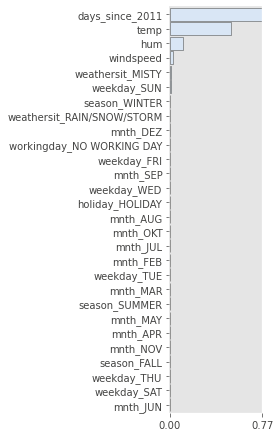

In [36]:
imp = rfpimp.importances(reg_random_forest, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

### Interpretation: permutation feature importance

## GBDT and XGBoost

Last but not least, we will use GBDT to model and predict the bike rental.

We will use the **XGBoost** package. Although it is not part of sklearn, it has a sklearn-style interface, which is very convenient for users.

If the **XGBoost** package is not installed, install it using the following command:

In [37]:
#! brew install libomp ## 先安装这个才能安装XGBoost
#! pip install XGBoost

In [38]:
#!conda install XGBoost

In [39]:
import xgboost as xgb
random_state_xgb = 200

In [40]:
xgb_model = xgb.XGBRegressor(random_state = random_state_xgb)

xgb_model.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=200,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

What is the performance of XGB regressor on the training and testing set?

In [41]:
print("R2 on the training data:")
print(xgb_model.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(xgb_model.score(X=test_x, y=test_y))

R2 on the training data:
0.9999505903854246
R2 on the testing data:
0.8795131843920542


What is the relative feature importance in this model?

Can you compare the variable importance with the CART and RF?

                                                         Importance
Feature                                                            
days_since_2011                                              0.7130
temp                                                         0.4908
hum                                                          0.1177
windspeed                                                    0.0492
weathersit_MISTY                                             0.0058
weekday_SAT                                                  0.0057
weekday_THU                                                  0.0039
workingday_NO WORKING DAY                                    0.0038
weekday_FRI                                                  0.0029
mnth_JUN                                                     0.0023
weathersit_RAIN/SNOW/STORM                                   0.0016
season_WINTER                                                0.0013
mnth_DEZ                                        

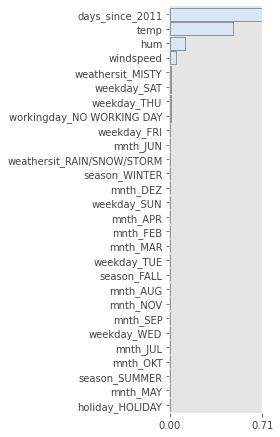

In [42]:
imp = rfpimp.importances(xgb_model, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

## Model comparison

We have built a range of regression models. Now we can collate these models and compare their performance.

In [44]:
# create a list of models
list_name_models = ['LR_VIF', 'LR_LASSO', 'CART', 'RF', 'GBDT']
# use the models from above
list_reg_models = [lr, lasso_model, reg_tree, reg_random_forest, xgb_model]

dict_models = dict()

# Element of dict_models: {'LR_VIF': [train_R2, test_R2]}

# Example
# data = {'row_1': [3, 2, 1, 0], 'row_2': ['a', 'b', 'c', 'd']}
# pd.DataFrame.from_dict(data, orient='index')
#        0  1  2  3
# row_1  3  2  1  0
# row_2  a  b  c  d

for name, model in zip(list_name_models, list_reg_models):
    if name == 'LR_VIF':
        dict_models[name] = [model.score(train_x_VIF, train_y), model.score(test_x_VIF, test_y)]
    else:
        dict_models[name] = [model.score(train_x, train_y), model.score(test_x, test_y)]

# transform dict_models to dataframe
df_models = pd.DataFrame.from_dict(dict_models, orient='index', columns=['R2_train_data', 'R2_test_data'])
print(df_models)
# you can then export df_models as a csv file and use it in MS Excel or Word

                                    R2_train_data  \
LR_VIF                                     0.8093   
LR_LASSO                                   0.8480   
CART                                       1.0000   
RF                                         0.9838   
GBDT                                       1.0000   

                                     R2_test_data  
LR_VIF                                     0.7474  
LR_LASSO                                   0.7925  
CART                                       0.7229  
RF                                         0.8851  
GBDT                                       0.8795  


## Summary

Well done for completing this workshop on regression. You will now have a stronger understanding of how to use a range of regression methods to gain insights into your datasets.

If you have time and/or interest in exploring these methods further, why not try these methods on a new dataset?

There are lots of nice datasets for analysis on [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.html) and [Kaggle](https://www.kaggle.com/datasets). Take a look, and if any of them take your fancy try create a regression model. Which data features are important? Which are not? 

We haven't talked about hyperparameter tuning of RF/XGBoost models. This topic will be discussed in the next weeks.

## Credits!

### Acknowledgements

This workshop is partially based on a [chapter](https://christophm.github.io/interpretable-ml-book/limo.html) of the [book](https://christophm.github.io/interpretable-ml-book/) by Christoph Molnar. 